In [1]:
from sklearn.neural_network import  MLPClassifier
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import numpy as np
from random import shuffle

#### 一个小小的怪问题

In [32]:
x = np.array([[0,0],[1,1],[1,0],[0,1]])
y = np.array([0,0,1,1])

(4,)

In [3]:
def plot_decision_boundary(ax, model, X, y, h=0.02):
    # 绘制决策边界

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))

    z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    
    cus=ListedColormap(["#EF9A9A","#FFF59D","#90CAF9"])
    ax.contourf(xx, yy, z, cmap=cus,alpha=0.5)

In [53]:
clf = MLPClassifier(hidden_layer_sizes=(2,),max_iter=22,activation="logistic",learning_rate_init=0.1)
clf.fit(x,y)

clf.score(x,y)

E:\ProgramData\Anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


0.75

#### torch的初体验

In [4]:

x = torch.arange(4.0,requires_grad=True)
print(x)

print(x.grad)

y = 2 * torch.dot(x,x)
y



tensor([0., 1., 2., 3.], requires_grad=True)
None


tensor(28., grad_fn=<MulBackward0>)

In [5]:
y.backward()


In [6]:
x.grad
x.grad.zero_()

y = x.sum()
y.backward()
x.grad



tensor([1., 1., 1., 1.])

In [7]:
x.grad.zero_()
y = x * x
y.sum().backward()
x.grad

x.grad.zero_()
y = x * x
u = y.detach()
print("u: ", u)
z = u*x
print("z: ", z)


u:  tensor([0., 1., 4., 9.])
z:  tensor([ 0.,  1.,  8., 27.], grad_fn=<MulBackward0>)


tensor([-3.1416e+01, -3.1102e+01, -3.0788e+01, -3.0473e+01, -3.0159e+01,
        -2.9845e+01, -2.9531e+01, -2.9217e+01, -2.8903e+01, -2.8588e+01,
        -2.8274e+01, -2.7960e+01, -2.7646e+01, -2.7332e+01, -2.7018e+01,
        -2.6704e+01, -2.6389e+01, -2.6075e+01, -2.5761e+01, -2.5447e+01,
        -2.5133e+01, -2.4819e+01, -2.4504e+01, -2.4190e+01, -2.3876e+01,
        -2.3562e+01, -2.3248e+01, -2.2934e+01, -2.2619e+01, -2.2305e+01,
        -2.1991e+01, -2.1677e+01, -2.1363e+01, -2.1049e+01, -2.0735e+01,
        -2.0420e+01, -2.0106e+01, -1.9792e+01, -1.9478e+01, -1.9164e+01,
        -1.8850e+01, -1.8535e+01, -1.8221e+01, -1.7907e+01, -1.7593e+01,
        -1.7279e+01, -1.6965e+01, -1.6650e+01, -1.6336e+01, -1.6022e+01,
        -1.5708e+01, -1.5394e+01, -1.5080e+01, -1.4765e+01, -1.4451e+01,
        -1.4137e+01, -1.3823e+01, -1.3509e+01, -1.3195e+01, -1.2881e+01,
        -1.2566e+01, -1.2252e+01, -1.1938e+01, -1.1624e+01, -1.1310e+01,
        -1.0996e+01, -1.0681e+01, -1.0367e+01, -1.0

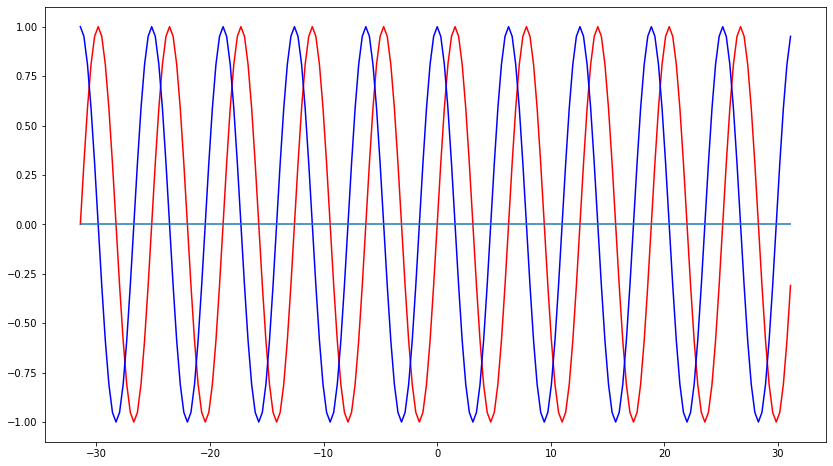

In [8]:
from matplotlib import pyplot as plt
x1 = torch.tensor(np.arange(-10,10,0.1)*np.pi,dtype=torch.float32,requires_grad=True)
print(x1)
x2 = torch.sin(x1)
x2.sum().backward()
plt.figure(figsize=(14,8))
plt.plot(x1.detach().numpy(),x2.detach().numpy(),linewidth=1.5,color='r')
plt.plot(x1.detach().numpy(),x1.grad.detach().numpy(),linewidth=1.5,color='b')
plt.hlines(0,float(x1.min()),float(x1.max()))


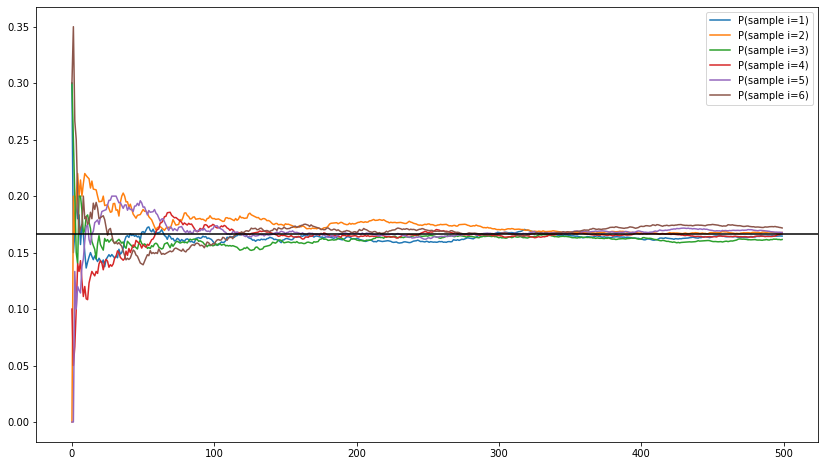

In [57]:
from torch.distributions import multinomial

fair_probs = torch.ones([6])
counts = multinomial.Multinomial(10,fair_probs).sample((500,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1,keepdim=True)
plt.figure(figsize=(14,8))
# print(cum_counts.sum(dim=1,keepdim=True))
for i in range(6):
    plt.plot(estimates[:, i].numpy(),label="P(sample i="+str(i+1)+")")
plt.legend()
plt.axhline(1/6,0,500,color="black")


#### 线性回归的torch实现


In [136]:
class LinearRegression(object):
    def __init__(self, weight:torch.Tensor=None) -> None:
        self.w = weight
        
    def data_iter(self, batch_size, X:torch.Tensor, y:torch.Tensor)-> tuple:
        num_sample = len(X)
        indices = list(range(num_sample))
        shuffle(indices)
        for i in range(0,num_sample,batch_size):
            batch_indices = torch.tensor(indices[i: min(i+batch_size, num_sample)])
            yield X[batch_indices], y[batch_indices]


    def loss(self, y:torch.Tensor, y_hat:torch.Tensor) -> torch.Tensor:
        return (y.reshape(y_hat.shape) - y_hat) ** 2 / 2
    
    def fit(self, X:torch.Tensor, y:torch.Tensor, \
        batch_size:int=16, epochs:int=10, lr:float=0.01, weight:torch.Tensor=None) -> None :
        
        # 对X拼接一列1
        X = torch.cat([X.clone(), torch.ones(X.shape[0], 1)], dim=1)
        if(self.w == None):
            self.w = torch.normal(mean=0, std=0.1, size=(X.shape[1], 1), dtype=torch.float32, requires_grad=True)
        else:
            self.w = weight

        for epoch in range(epochs):
            # 小批量取出数据
            for feature,label in self.data_iter(batch_size, X, y):
                # 预测值计算
                l = self.loss(label, self.linereg(feature))
                
                # 损失梯度反向传播(得到梯度)
                l.sum().backward()
                # 进行梯度更新
                self.sgd(lr, batch_size)

    def sgd(self, lr:float, batch_size:int) -> None:
        with torch.no_grad():
            self.w -= lr * self.w.grad / batch_size
            self.w.grad.zero_()


    def linereg(self, X:torch.Tensor)->torch.Tensor:
        if X.shape[1] != self.w.shape[0]:
            X_copy = torch.cat([X.clone(), torch.ones(X.shape[0], 1)], dim=1)
            return torch.matmul(X_copy, self.w)
        return torch.matmul(X, self.w)

In [ ]:
from sklearn.datasets import load_boston

iris = load_boston()

feature = iris.data
label = iris.target
feature = torch.tensor(feature,dtype=torch.float32)
label = torch.tensor(label,dtype=torch.float32)
feature.shape,label.shape

In [119]:
feature.shape

torch.Size([506, 13])

In [141]:
reg = LinearRegression()
reg.fit(feature[:406],label[:406])

结果为nan，由于数据集各特征量纲不一样，造成梯度传播容易爆炸，在上面归一化处理一下即可正常训练

In [138]:
reg.w

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], requires_grad=True)

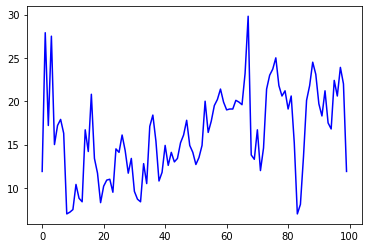

In [133]:
y_pred = reg.linereg(feature[406:])

plt.plot(label[406:].detach().numpy(),color="b")
plt.plot(y_pred.detach().numpy(),color="r")